In [1]:
import sys
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split

In [2]:
# parameters
USE_PCA = True
UNDERSAMPLE = False
OVERSAMPLE = not UNDERSAMPLE

In [3]:
# 1 - exploratory data analysis

# read the file
filePath_red = "data/winequality-red.csv"
filePath_white = "data/winequality-white.csv"

# merge red and white wines
red_data = pd.read_csv(filePath_red, sep = ';')
red_data.insert(loc = 0, column='type', value = 'red')
white_data = pd.read_csv(filePath_white, sep = ';')
white_data.insert(loc = 0, column='type', value = 'white')
frames = [red_data, white_data]
full_dataset = pd.concat(frames, ignore_index=True)

# basic exploration
full_dataset.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,red,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,red,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,red,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
type                    6497 non-null object
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Red/white distribution: 
white    4898
red      1599
Name: type, dtype: int64


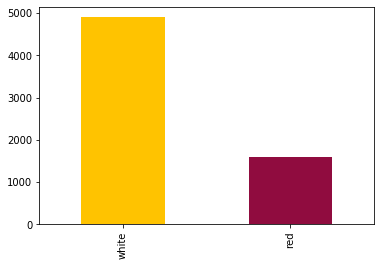

In [5]:
# red, white distribution
print("Red/white distribution: ")
print(full_dataset['type'].value_counts())
full_dataset['type'].value_counts().plot(kind='bar', color = ['#FFC300', '#900C3F'])

Quality distribution: 
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64


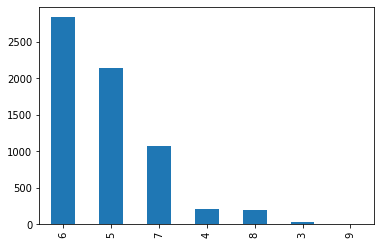

In [6]:
# classes distribution (histogram)
print("Quality distribution: ")
print(full_dataset['quality'].value_counts())
full_dataset['quality'].value_counts().plot(kind='bar')

In [7]:
# missing values
full_dataset.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [8]:
# binning
# 0 to 5 => 0
# 6 to 10 => 1
bins = [0,5,10]

labels = [0, 1] # 'low'=0, 'high'=1
full_dataset['quality_range']= pd.cut(x=full_dataset['quality'], bins=bins, labels=labels)
full_dataset = full_dataset.drop('quality', axis=1) 

In [9]:
full_dataset.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_range
0,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,red,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,red,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,red,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Quality distribution: 
1    4113
0    2384
Name: quality_range, dtype: int64


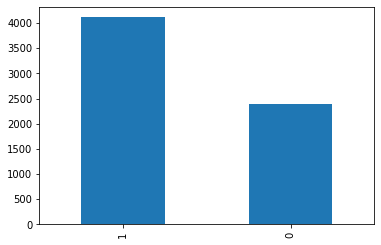

In [10]:
# quality_range distribution
# still not balanced
print("Quality distribution: ")
print(full_dataset['quality_range'].value_counts())
full_dataset['quality_range'].value_counts().plot(kind='bar')

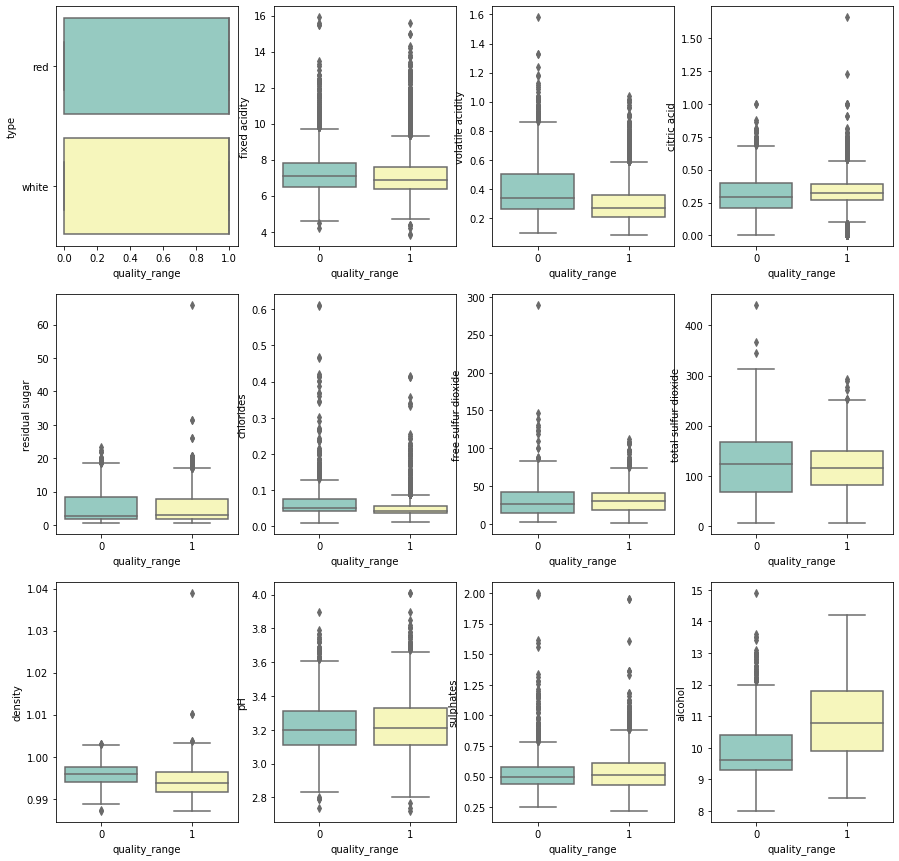

In [11]:
# features distribution

# boxplots
def plotBoxplots(df, class_label, cols=4):
    cols_list = []
    for c in df.columns:
        if c not in ['type_red', 'type_white', 'quality_range']:
            cols_list += [c]
    rows = math.ceil(len(cols_list)/cols)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))

    for i, c in enumerate(cols_list):
        ax = None
        if rows > 1:
            ax = axes[i//cols][i%cols]
        else:
            ax = axes[i%cols]
        ax = sns.boxplot(x=class_label, y=c, data=df, palette="Set3", ax=ax)
        
plotBoxplots(full_dataset, 'quality_range')

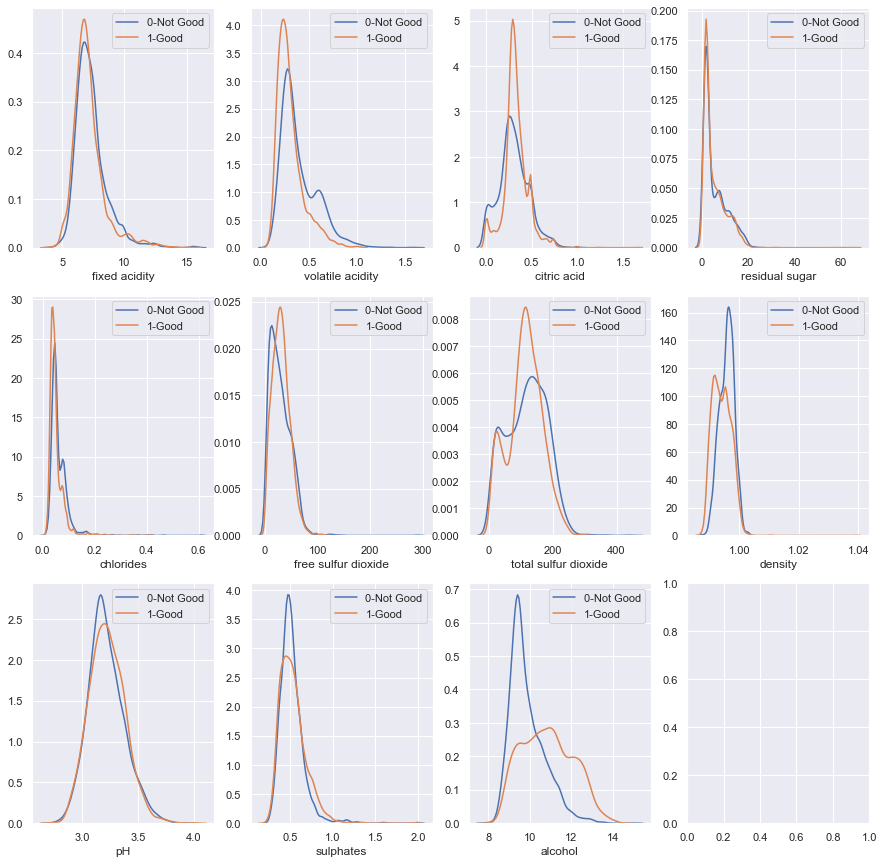

In [28]:
# distribution plots
from scipy.stats import norm 


#sns.distplot(target_1['age'],hist=False,label="<=50K")
#sns.distplot(target_0['age'],hist=False,label=">50K")

def plotDistPlots(df, class_label, cols=4):
    target_0 = df.loc[df[class_label] == 0]
    target_1 = df.loc[df[class_label] == 1]
    cols_list = []
    for c in df.columns:
        if c not in ['type', 'quality_range']:
            cols_list += [c]
    rows = math.ceil(len(cols_list)/cols)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))

    for i, c in enumerate(cols_list):
        ax = None
        if rows > 1:
            ax = axes[i//cols][i%cols]
        else:
            ax = axes[i%cols]
        ax = sns.distplot(target_0[c], ax = ax,hist=False, label="0-Not Good")
        ax = sns.distplot(target_1[c], ax = ax,hist=False, label="1-Good")



        
plotDistPlots(full_dataset, 'quality_range')

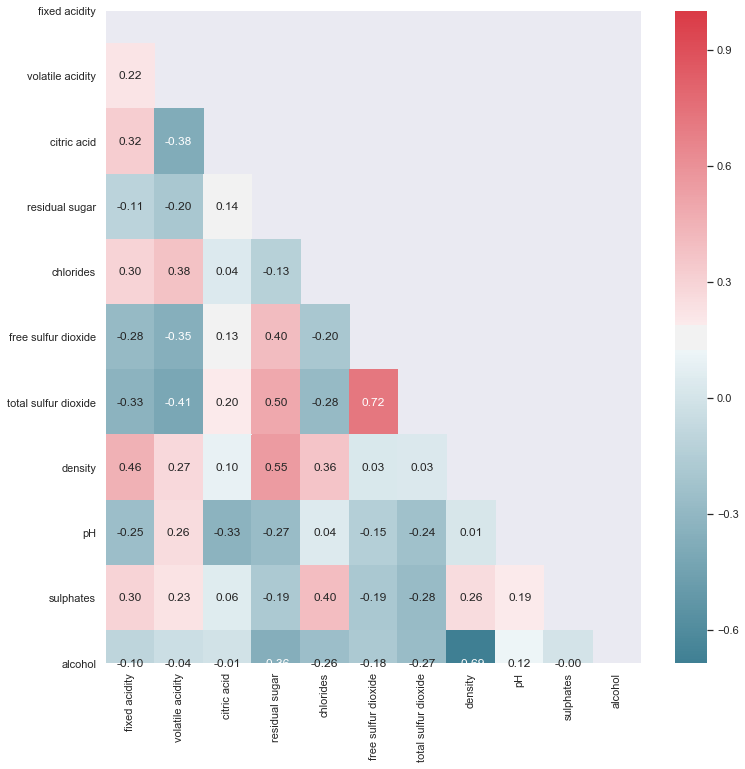

In [14]:
# features correlation
corr_matrix = full_dataset.loc[:, full_dataset.columns != 'quality'].corr()
#corr_list = corr_matrix.quality.abs().sort_values(ascending=False).index[0:]

plt.figure(figsize=(12, 12))
dropSelf = np.zeros_like(corr_matrix)
dropSelf[np.triu_indices_from(dropSelf)] = True

sns.heatmap(corr_matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)

sns.set(font_scale=1)

In [15]:
# 2 - preprocessing

# features selection
dataset = full_dataset.drop(['free sulfur dioxide'], axis=1)
dataset.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol,quality_range
0,red,7.4,0.70,0.00,1.9,0.076,34.0,0.9978,3.51,0.56,9.4,0
1,red,7.8,0.88,0.00,2.6,0.098,67.0,0.9968,3.20,0.68,9.8,0
2,red,7.8,0.76,0.04,2.3,0.092,54.0,0.9970,3.26,0.65,9.8,0
3,red,11.2,0.28,0.56,1.9,0.075,60.0,0.9980,3.16,0.58,9.8,1
4,red,7.4,0.70,0.00,1.9,0.076,34.0,0.9978,3.51,0.56,9.4,0


In [16]:
# type balancing
def undersample(df, class_label):
    categories = list(df[class_label].unique())
    rows_to_keep = sys.maxsize
    for c in categories:
        rows_to_keep = min(rows_to_keep, (df[class_label].str.contains(c).sum()))
    dfs = []
    for c in categories:
        dfs.append(df[df[class_label].str.contains(c)].sample(n=rows_to_keep))
    return pd.concat(dfs).sort_index()

def oversample(df, class_label):
    categories = list(df[class_label].unique())
    rows_to_keep = 0
    for c in categories:
        rows_to_keep = max(rows_to_keep, (df[class_label].str.contains(c).sum()))
    dfs = []
    for c in categories:
        dfs.append(df[df[class_label].str.contains(c)].sample(n=rows_to_keep, replace = True))
    return pd.concat(dfs, ignore_index = True).sort_index()

In [17]:
if UNDERSAMPLE:
    resampled_dataset = undersample(dataset, 'type')
elif OVERSAMPLE:
    resampled_dataset = oversample(dataset, 'type')  
else:
    resampled_dataset = dataset # no under nor over sampling applied

# 0ld
# one hot encoding type
#encoded_full_dataset = pd.concat([undersampled_dataset, pd.get_dummies(undersampled_dataset['type'], prefix='type')],axis=1)
#encoded_full_dataset.drop(['type'],axis=1, inplace=True)

# simpler encoding
encoded_full_dataset = resampled_dataset
encoded_full_dataset.type = resampled_dataset.type.map({'white':0, 'red':1})

encoded_full_dataset.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol,quality_range
0,1,8.2,0.310,0.40,2.2,0.058,10.0,0.99536,3.31,0.68,11.2,1
1,1,10.4,0.410,0.55,3.2,0.076,54.0,0.99960,3.15,0.89,9.9,1
2,1,6.7,0.320,0.44,2.4,0.061,34.0,0.99484,3.29,0.80,11.6,1
3,1,7.3,0.660,0.00,2.0,0.084,23.0,0.99830,3.61,0.96,9.9,1
4,1,7.0,0.685,0.00,1.9,0.067,63.0,0.99790,3.60,0.81,9.9,0


In [18]:
def undersample2(df, class_label):
    categories = list(df[class_label].unique())
    rows_to_keep = sys.maxsize
    for c in categories:
        rows_to_keep = min(rows_to_keep, (len(df.loc[df[class_label] == c])))
    dfs = []
    for c in categories:
        dfs.append(df.loc[df[class_label] == c].sample(n=rows_to_keep))
    return pd.concat(dfs).sort_index()

def oversample2(df, class_label):
    categories = list(df[class_label].unique())
    rows_to_keep = 0
    for c in categories:
        rows_to_keep = max(rows_to_keep, (len(df.loc[df[class_label] == c])))
    dfs = []
    for c in categories:
        dfs.append(df.loc[df[class_label] == c].sample(n=rows_to_keep, replace = True))
    return pd.concat(dfs, ignore_index = True).sort_index()

Quality distribution: 
1    5861
0    3935
Name: quality_range, dtype: int64


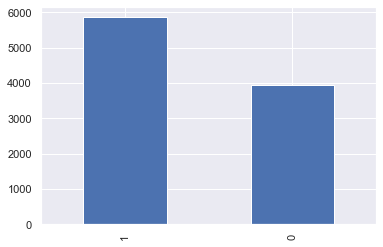

In [19]:
# class balancing
print("Quality distribution: ")
print(encoded_full_dataset['quality_range'].value_counts())
encoded_full_dataset['quality_range'].value_counts().plot(kind='bar')

if UNDERSAMPLE:
    balanced_dataset = undersample2(encoded_full_dataset, 'quality_range')
elif OVERSAMPLE: 
    balanced_dataset = oversample2(encoded_full_dataset, 'quality_range')
else:
    balanced_dataset =  encoded_full_dataset

6005
5717


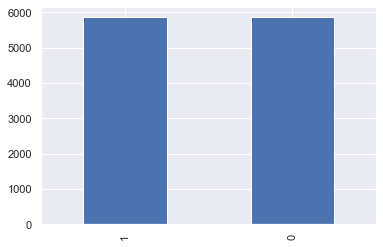

In [20]:
# test all balanced
# ok

# class
balanced_dataset['quality_range'].value_counts().plot(kind='bar')

# type
print(len(balanced_dataset.loc[balanced_dataset["type"] == 1])) #red
print(len(balanced_dataset.loc[balanced_dataset["type"] == 0])) #white

In [20]:
# standardization and normalization
# concatenate scaled DF with the categorical columns (type)
last_columns = balanced_dataset[balanced_dataset.columns[-2:]]

def getXY(df, class_label):
    X = df.loc[:, 'type':'alcohol']
    y = df[class_label]
    return X, y

X, y = getXY(balanced_dataset, 'quality_range')

to_scale = X.loc[:, 'fixed acidity':'alcohol']
scaler = StandardScaler().fit(to_scale)
scaledData = scaler.transform(to_scale)
X.loc[:,'fixed acidity':'alcohol'] = scaledData
train_X = X

print(train_X.head())
train_X.describe()

   type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0     1       0.186032          1.369574    -0.530049       -0.554396   
1     1       0.121740          0.565796     0.187682       -0.485870   
2     0      -0.199717         -0.187746    -0.410427        0.450652   
3     0      -0.649757         -0.840816     0.367114        0.816124   
4     1       1.021821          0.616032     0.068060       -0.508712   

   chlorides  total sulfur dioxide   density        pH  sulphates   alcohol  
0   0.260271              0.796193  0.213098 -0.015564  -0.374431 -0.417429  
1   0.260271              0.845807  0.333631  0.281147   0.153749 -0.768899  
2  -0.401997              0.151214 -0.875135 -0.905696  -0.139684  0.724851  
3  -0.512375              1.441172  0.075347 -1.024381  -0.902611 -1.032502  
4   0.966690             -0.907214  0.485157 -0.074906  -0.080998  0.461248  


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol
count,11942.000000,1.194200e+04,1.194200e+04,1.194200e+04,1.194200e+04,1.194200e+04,1.194200e+04,1.194200e+04,1.194200e+04,1.194200e+04,1.194200e+04
mean,0.513649,1.308988e-16,1.332788e-16,-1.427987e-16,4.759958e-18,-1.427987e-16,-4.164963e-17,1.947775e-14,-1.005541e-15,2.570377e-16,5.521551e-16
std,0.499835,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00
min,0.000000,-2.449918e+00,-1.694830e+00,-1.786077e+00,-8.970258e-01,-1.240870e+00,-1.436428e+00,-2.917295e+00,-3.042015e+00,-2.076345e+00,-2.086914e+00
25%,0.000000,-6.497572e-01,-7.905798e-01,-5.300490e-01,-6.000798e-01,-5.344505e-01,-9.237518e-01,-6.478459e-01,-6.683277e-01,-6.678647e-01,-7.688995e-01
50%,1.000000,-1.997170e-01,-2.379822e-01,8.248912e-03,-4.858697e-01,-1.812410e-01,-6.377946e-02,1.579979e-01,-1.556354e-02,-1.396844e-01,-2.416935e-01
75%,1.000000,3.789061e-01,7.165044e-01,6.063577e-01,3.136003e-01,2.823465e-01,7.465791e-01,6.676769e-01,6.372006e-01,3.884959e-01,6.369832e-01
max,1.000000,5.329349e+00,5.840591e+00,8.142528e+00,1.399596e+01,1.198241e+01,5.741034e+00,1.494558e+01,4.494443e+00,8.369887e+00,3.975954e+00


In [21]:
print(train_X.isnull().sum())

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64


Total explained variance with 11 components: 0.9999999999999999


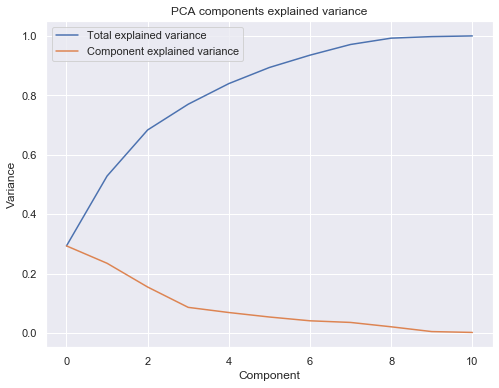

In [22]:
# PCA
def plotExplainedVariance(pcaModel, n_components=None):
    x = [i for i in range(len(pcaModel.explained_variance_ratio_))]
    y = []
    var_sum = 0
    for var in pcaModel.explained_variance_ratio_:
        var_sum += var
        y += [var_sum]
    if n_components is not None:
        print('Total explained variance with {} components: {}'.format(n_components, y[n_components-1]))
    
    plt.figure(figsize=(8, 6))
    plt.title('PCA components explained variance')
    plt.xlabel('Component')
    plt.ylabel('Variance')
    sns.lineplot(y=y, x=x, label='Total explained variance')
    sns.lineplot(y=pcaModel.explained_variance_ratio_, x=x, label='Component explained variance')
    
pca = PCA().fit(train_X)
n_components = len(train_X.columns)
plotExplainedVariance(pca, n_components = n_components)

# with 5 components we have 82% of explained variance
# with 6 components we have 87% of explained variance

In [23]:
# Model selection
from sklearn.model_selection import train_test_split

# train test split 80/20
X, y = getXY(balanced_dataset, 'quality_range')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1, shuffle = True)

if not USE_PCA:
    transform = make_pipeline(StandardScaler())
else:
    transform = make_pipeline(StandardScaler(), PCA(n_components = 6))
    
def getDataDict(X_train, X_test, y_train, y_test, transform=None):
    
    if transform is not None:
        t = transform.fit(X_train)
        X_train = t.transform(X_train)
        X_test = t.transform(X_test)
    
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = getDataDict(X_train, X_test, y_train, y_test, transform=transform)

In [24]:
# gridsearch
def test_util(model, X_test, y_test, plot=True):
    test_preds = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_preds)
    test_recall = recall_score(y_test, test_preds)
    test_precision = precision_score(y_test, test_preds)
    test_f1 = f1_score(y_test, test_preds)
    
    if plot:
        plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
        plot_roc_curve(model, X_test, y_test)
    
    return test_acc, test_recall, test_precision, test_f1

def build_train_val(X, y, kf):
    indices = []
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        train_DF = pd.DataFrame(X_train)
        train_DF['train_index'] = train_index
        train_DF['y'] = y_train
        train_DF = undersample2(train_DF, 'y')
        train_index = list(train_DF['train_index'])
        indices += [(train_index, val_index)]
    return indices

def GridSearchCV_routine(model, X_train, y_train, X_test, y_test, param_grid, splits=5, stratified=False, undersample=False, shuffle=False, seed=None):
    if stratified:
        kf = StratifiedKFold(n_splits=splits, shuffle=shuffle, random_state=seed)
    else:
        kf = KFold(n_splits=splits, shuffle=shuffle, random_state=seed)
        
    if undersample:
        cv = build_train_val(X_train, y_train, kf)
    else:
        cv = kf
    
    search = GridSearchCV(model, param_grid, cv = cv, scoring='accuracy')
    search.fit(X_train, y_train)
    
    print('Train - Accuracy: {}'.format(search.best_score_))
    
    scores = test_util(search, X_test, y_test)
    test_acc, test_recall, test_precision, test_f1 = scores
    print('Test - Accuracy: {} Recall: {} Precision: {} F1: {}'.format(test_acc, test_recall, test_precision, test_f1))
    
    return search.best_estimator_, scores

Train - Accuracy: 0.9643037142363994
Test - Accuracy: 0.9640016743407284 Recall: 0.9568162574089755 Precision: 0.9699570815450643 F1: 0.9633418584825234


(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='entropy', max_depth=20, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=80,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 (0.9640016743407284,
  0.9568162574089755,
  0.9699570815450643,
  0.9633418584825234))

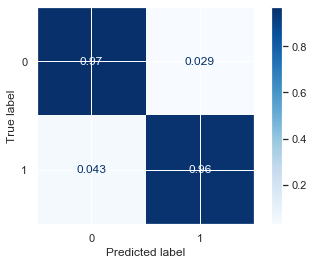

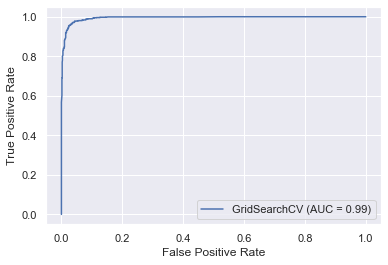

In [25]:
# apply the models
# 1 - random forests
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [10, 50, 80],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 20, 50, 100],
    'bootstrap': [True, False]
}

GridSearchCV_routine(rf, X_train, y_train, X_test, y_test, param_grid)

Train - Accuracy: 0.7891745502067117
Test - Accuracy: 0.8053578903306823 Recall: 0.7781541066892464 Precision: 0.8190730837789661 F1: 0.7980894485453757


(SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 (0.8053578903306823,
  0.7781541066892464,
  0.8190730837789661,
  0.7980894485453757))

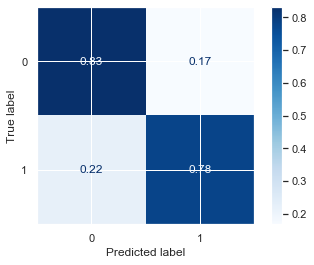

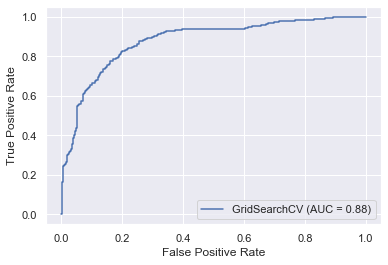

In [26]:
#2
svc = SVC()
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

GridSearchCV_routine(svc, X_train, y_train, X_test, y_test, param_grid)

Train - Accuracy: 0.7124458837099076
Test - Accuracy: 0.7187107576391796 Recall: 0.6917866215071973 Precision: 0.7262222222222222 F1: 0.7085862966175195


(LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                            solver='svd', store_covariance=False, tol=0.0001),
 (0.7187107576391796,
  0.6917866215071973,
  0.7262222222222222,
  0.7085862966175195))

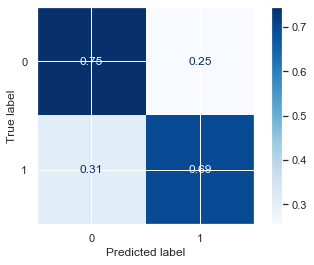

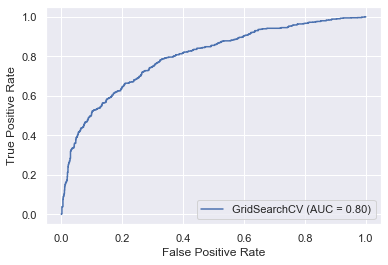

In [27]:
lda = LinearDiscriminantAnalysis()
param_grid = {
    
}

GridSearchCV_routine(lda, X_train, y_train, X_test, y_test, param_grid, undersample = False)

Train - Accuracy: 0.951114051742324
Test - Accuracy: 0.9581414817915446 Recall: 0.9458086367485182 Precision: 0.96877710320902 F1: 0.9571550985432735


(DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 (0.9581414817915446,
  0.9458086367485182,
  0.96877710320902,
  0.9571550985432735))

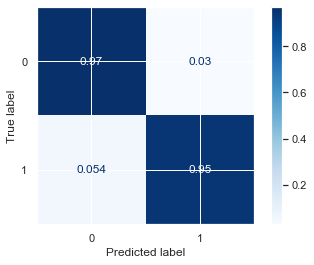

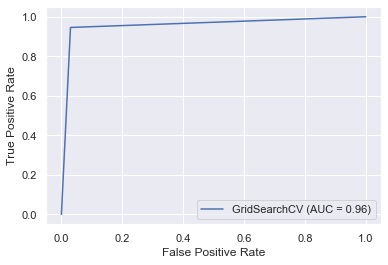

In [28]:
dt = DecisionTreeClassifier()
param_grid = {}

GridSearchCV_routine(dt, X_train, y_train, X_test, y_test, param_grid, undersample = False)

Train - Accuracy: 0.9576047188911812
Test - Accuracy: 0.961490163248221 Recall: 0.9593564775613886 Precision: 0.9626168224299065 F1: 0.9609838846480068


(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                      weights='uniform'),
 (0.961490163248221,
  0.9593564775613886,
  0.9626168224299065,
  0.9609838846480068))

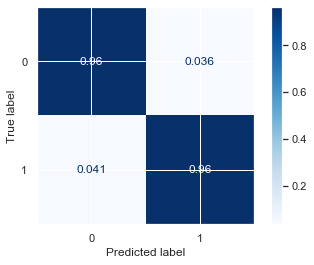

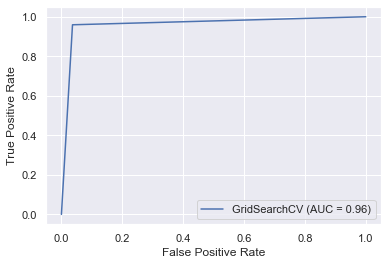

In [29]:
neigh = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [1, 3, 5, 10],
    'metric': ['minkowski', 'euclidean']
}

GridSearchCV_routine(neigh, X_train, y_train, X_test, y_test, param_grid, undersample = False)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


Train - Accuracy: 0.7143297141651666
Test - Accuracy: 0.722059439095856 Recall: 0.7061812023708721 Precision: 0.7245873153779322 F1: 0.7152658662092624


(LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 (0.722059439095856,
  0.7061812023708721,
  0.7245873153779322,
  0.7152658662092624))

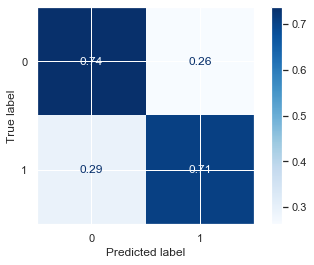

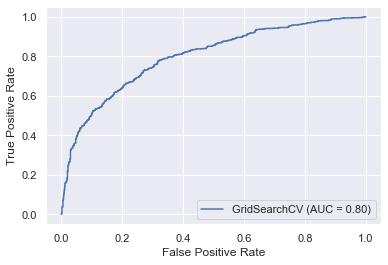

In [30]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

GridSearchCV_routine(lr, X_train, y_train, X_test, y_test, param_grid, undersample = False)